# Neural Collaborative Filtering

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim

In [3]:
# ratings = pd.read_csv('../../data/lens_tmdb/ratings.csv')
ratings = pd.read_csv('../../data/lens_tmdb/ratings_small.csv')

In [4]:
# Convert userId and movieId to categorical
ratings['userId'] = ratings['userId'].astype('category')
ratings['movieId'] = ratings['movieId'].astype('category')

# Define the number of users and movies
num_users = ratings['userId'].nunique()
num_movies = ratings['movieId'].nunique()

In [5]:
# Train test split
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)

# Data Loader for Training and Test

In [6]:
from torch.utils.data import DataLoader, TensorDataset
# Convert train and test ratings dataframes into tensors
train_dataset = TensorDataset(
    torch.tensor(train_ratings['userId'].cat.codes.values, dtype=torch.int64),
    torch.tensor(train_ratings['movieId'].cat.codes.values, dtype=torch.int64),
    torch.tensor(train_ratings['rating'].values, dtype=torch.float32)
)

test_dataset = TensorDataset(
    torch.tensor(test_ratings['userId'].cat.codes.values, dtype=torch.int64),
    torch.tensor(test_ratings['movieId'].cat.codes.values, dtype=torch.int64),
    torch.tensor(test_ratings['rating'].values, dtype=torch.float32)
)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Neural Collaborative Filtering Model Architecture

In [7]:
class NCF(nn.Module):
    def __init__(self, num_users, num_items, emb_size=100, hidden_layers=[100], dropout=False):
        super(NCF, self).__init__()
        self.user_emb = nn.Embedding(num_users, emb_size)
        self.item_emb = nn.Embedding(num_items, emb_size)
        self.hidden_layers = nn.ModuleList()
        input_size = 2 * emb_size

        for hidden_layer_size in hidden_layers:
            self.hidden_layers.append(nn.Linear(input_size, hidden_layer_size))
            input_size = hidden_layer_size

        self.output_layer = nn.Linear(input_size, 1)
        self.dropout = dropout

    def forward(self, user_indices, item_indices):
        user_embedding = self.user_emb(user_indices)
        item_embedding = self.item_emb(item_indices)
        x = torch.cat([user_embedding, item_embedding], dim=-1)  # concatenate user and item embeddings

        for hidden_layer in self.hidden_layers:
            x = hidden_layer(x)
            x = torch.relu(x)
            if self.dropout:
                x = nn.Dropout()(x)

        x = self.output_layer(x)
        return 1 + 4*torch.sigmoid(x).view(-1)  # This scales the sigmoid output to the range [1, 5]


In [8]:
def rmse(predictions, targets):
    return torch.sqrt(((predictions - targets) ** 2).mean())

def mae(predictions, targets):
    return torch.abs(predictions - targets).mean()

def mse(predictions, targets):
    return (predictions - targets).mean()


# Training and Evaluation

In [9]:
# Create the NCF model, loss function, and optimizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NCF(num_users=num_users, num_items=num_movies, emb_size=100, hidden_layers=[128, 64, 32], dropout=True).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
# Lists to store metrics
train_losses = []
test_losses = []
train_rmses = []
test_rmses = []
train_maes = []
test_maes = []
train_mses = []
test_mses = []

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_rmse_val = 0
    train_mae_val = 0
    train_mse_val = 0
    for users, movies, ratings in train_loader:
        users, movies, ratings = users.to(device), movies.to(device), ratings.to(device)

        optimizer.zero_grad()
        outputs = model(users, movies)
        loss = criterion(outputs, ratings)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_rmse_val += rmse(outputs, ratings).item()
        train_mae_val += mae(outputs, ratings).item()
        train_mse_val += mse(outputs, ratings).item()

    train_loss /= len(train_loader)
    train_rmse_val /= len(train_loader)
    train_mae_val /= len(train_loader)
    train_mse_val /= len(train_loader)
    train_losses.append(train_loss)
    train_rmses.append(train_rmse_val)
    train_maes.append(train_mae_val)
    train_mses.append(train_mse_val)

    model.eval()
    test_loss = 0
    test_rmse_val = 0
    test_mae_val = 0
    test_mse_val = 0
    with torch.no_grad():
        for users, movies, ratings in test_loader:
            users, movies, ratings = users.to(device), movies.to(device), ratings.to(device)

            outputs = model(users, movies)
            loss = criterion(outputs, ratings)

            test_loss += loss.item()
            test_rmse_val += rmse(outputs, ratings).item()
            test_mae_val += mae(outputs, ratings).item()
            test_mse_val += mse(outputs, ratings).item()

    test_loss /= len(test_loader)
    test_rmse_val /= len(test_loader)
    test_mae_val /= len(test_loader)
    test_mse_val /= len(test_loader)
    test_losses.append(test_loss)
    test_rmses.append(test_rmse_val)
    test_maes.append(test_mae_val)
    test_mses.append(test_mse_val)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    print(f'Epoch {epoch+1}/{num_epochs}, Train RMSE: {train_rmse_val:.4f}, Test RMSE: {test_rmse_val:.4f}')
    print(f'Epoch {epoch+1}/{num_epochs}, Train MAE: {train_mae_val:.4f}, Test MAE: {test_mae_val:.4f}')
    print(f'Epoch {epoch+1}/{num_epochs}, Train MSE: {train_mse_val:.4f}, Test MSE: {test_mse_val:.4f}')


Epoch 1/10, Train Loss: 1.0854, Test Loss: 1.0132
Epoch 1/10, Train RMSE: 1.0400, Test RMSE: 1.0056
Epoch 1/10, Train MAE: 0.8288, Test MAE: 0.7901
Epoch 1/10, Train MSE: -0.0419, Test MSE: 0.0339
Epoch 2/10, Train Loss: 0.9637, Test Loss: 0.9470
Epoch 2/10, Train RMSE: 0.9805, Test RMSE: 0.9722
Epoch 2/10, Train MAE: 0.7708, Test MAE: 0.7663
Epoch 2/10, Train MSE: -0.0044, Test MSE: -0.0536
Epoch 3/10, Train Loss: 0.9043, Test Loss: 0.9156
Epoch 3/10, Train RMSE: 0.9500, Test RMSE: 0.9560
Epoch 3/10, Train MAE: 0.7431, Test MAE: 0.7456
Epoch 3/10, Train MSE: -0.0029, Test MSE: 0.0083
Epoch 4/10, Train Loss: 0.8577, Test Loss: 0.8922
Epoch 4/10, Train RMSE: 0.9250, Test RMSE: 0.9436
Epoch 4/10, Train MAE: 0.7216, Test MAE: 0.7343
Epoch 4/10, Train MSE: 0.0023, Test MSE: 0.0064
Epoch 5/10, Train Loss: 0.8215, Test Loss: 0.8784
Epoch 5/10, Train RMSE: 0.9053, Test RMSE: 0.9362
Epoch 5/10, Train MAE: 0.7050, Test MAE: 0.7309
Epoch 5/10, Train MSE: -0.0000, Test MSE: -0.0228
Epoch 6/10, Tr

# Visualizations

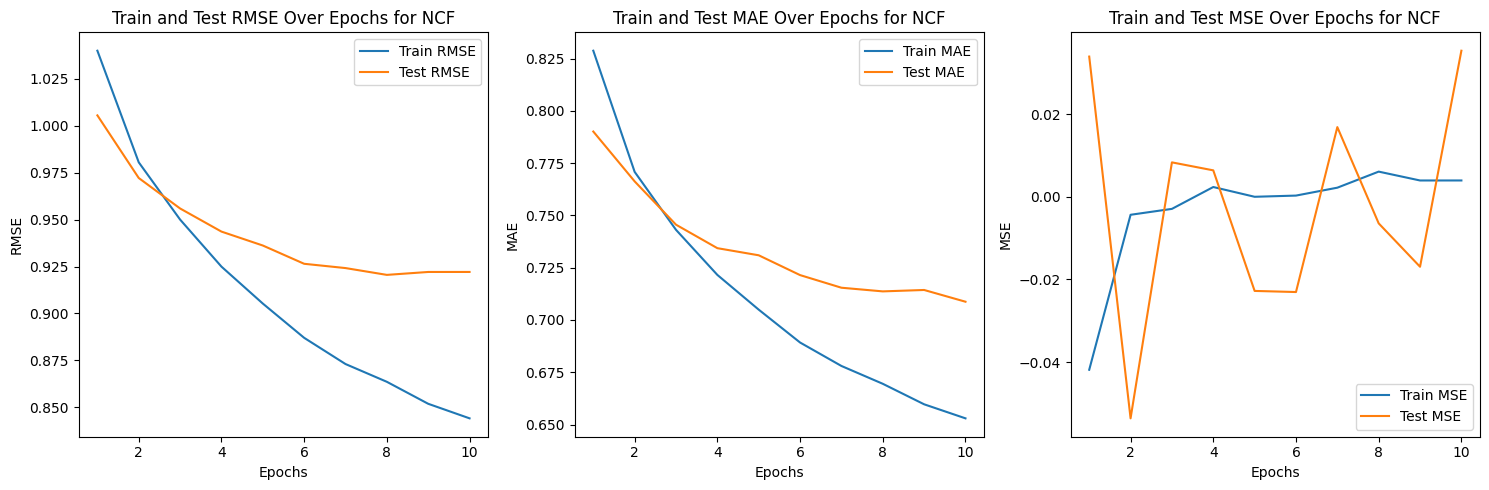

In [11]:
# Visualization
import matplotlib.pyplot as plt
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(15, 5))

# Plotting RMSE for training and test data
plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_rmses, label='Train RMSE')
plt.plot(epochs_range, test_rmses, label='Test RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.title('Train and Test RMSE Over Epochs for NCF')

# Plotting MAE for training and test data
plt.subplot(1, 3, 2)
plt.plot(epochs_range, train_maes, label='Train MAE')
plt.plot(epochs_range, test_maes, label='Test MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('Train and Test MAE Over Epochs for NCF')

# Plotting MSE for training and test data
plt.subplot(1, 3, 3)
plt.plot(epochs_range, train_mses, label='Train MSE')
plt.plot(epochs_range, test_mses, label='Test MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.title('Train and Test MSE Over Epochs for NCF')

plt.tight_layout()
plt.show()
